In [14]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
from torch.nn.utils import weight_norm
from deepsith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")
import itertools
from csv import DictWriter
import matplotlib.pylab as plt
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sn
sn.set_context('talk')

<class 'torch.cuda.FloatTensor'>


In [16]:
def generate_noise(maxn=18):
    """Generates dot and dash based noise."""
    
    threes = np.random.randint(int(.5*maxn), int(.75*maxn))
    ones = (maxn - threes) * 2
    noise = list(itertools.repeat([1,1,1,0], threes))
    noise[:int(len(noise)/3)] = list(itertools.repeat([0,0], int(len(noise)/3)))
    ones = ones + int(len(noise)/3)
    noise.extend(list(itertools.repeat([1,0], ones)))
    random.shuffle(noise)
    noise = np.concatenate(noise)
    return noise

(400,)


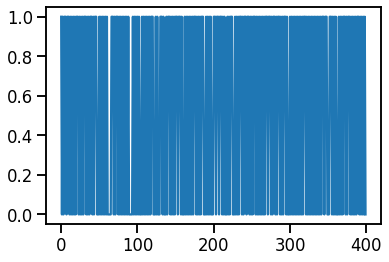

In [17]:
noise = generate_noise(maxn=100)
print(noise.shape)
plt.plot(noise)

In [18]:

signals = ttype([[0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,0],
                 [0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0],
                ]
               ).view(8, 1, 1, -1)


In [19]:
torch.manual_seed(12345)
np.random.seed(12345)
training_samples = 32
maxn=6
training_signals = []
training_class = []

for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(training_samples):
        noise = ttype(generate_noise(maxn))
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        c=0
        while(any([(temp == c_).all() for c_ in temp_signals])):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            c += 1
            if c == 100:
                1/0
        temp_signals.append(temp)
        temp_class.append(i)
    training_signals.extend(temp_signals)
    training_class.extend(temp_class)

batch_rand = torch.randperm(training_samples*signals.shape[0])        
training_signals = torch.cat(training_signals).cuda()[batch_rand]
training_class  = ctype(training_class).cuda()[batch_rand]

dataset = torch.utils.data.TensorDataset(training_signals, training_class)
dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)



In [20]:
testing_samples = 10
testing_signals = []
testing_class = []
for i, sig in enumerate(signals):
    temp_signals = []
    temp_class = []
    for x in range(testing_samples):
        noise = ttype(generate_noise(maxn))
        temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        while(any([(temp == c_).all() for c_ in temp_signals]) or any([(temp == c_).all() for c_ in training_signals])):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        temp_signals.append(temp)
        temp_class.append(i)
    testing_signals.extend(temp_signals)
    testing_class.extend(temp_class)
batch_rand = torch.randperm(testing_samples*signals.shape[0])

testing_signals = torch.cat(testing_signals).cuda()[batch_rand]
testing_class  = ctype(testing_class)[batch_rand]


dataset_valid = torch.utils.data.TensorDataset(testing_signals, testing_class)
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=False)

print(testing_signals.shape, testing_class.shape)


torch.Size([80, 1, 1, 41]) torch.Size([80])


In [21]:
def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, 
          permute=None, loss_buffer_size=64, batch_size=4, device='cuda',
          prog_bar=None, maxn=6):
    
    assert(loss_buffer_size%batch_size==0)
        
    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out[:, -1, :],
                         target)

        loss.backward()
        optimizer.step()

        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = test(model, 'cuda', test_loader, 
                                  batch_size=batch_size, 
                                  permute=permute)
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['pres_num'] = batch_idx*batch_size + epoch*len(train_loader.dataset)
            loss_track['maxn'] = maxn
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)

                
def test(model, device, test_loader, batch_size=4, permute=None):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            out = model(data)
            pred = out[:, -1].argmax(dim=-1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += 1
    return correct / len(test_loader.dataset)

# Setup Classifier type model

In [22]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

# Training and testing

In [23]:
# You likely don't need this to be this long, but just in case.
epochs = 1000

# Just for visualizing average loss through time. 
loss_buffer_size = 100

In [24]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = int(args[2])
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

   direc: array([[0.81910364]])
     fun: 0.1347234
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([17.00981707])
ntau: 15 k: 17


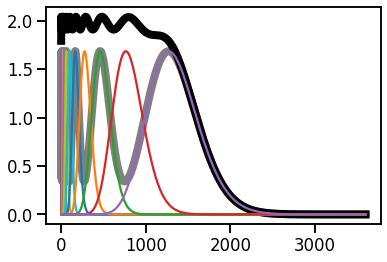

In [25]:
ntau_0 = 15
k_0 = 20
tau_min = 1.
tau_max = 1200.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau_0), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)
ntau=ntau_0
k = int(res.x)
print('ntau:', ntau, 'k:', k)
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, k=k, ntau=ntau, dt=1.0, g=1.0)
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
        linewidth=8, color='grey');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );

In [26]:
test_noise_lengths = [6,7,9,13,21,37]
for maxn in test_noise_lengths:
    torch.manual_seed(12345)
    np.random.seed(12345)
    training_samples = 64
    training_signals = []
    training_class = []
    for i, sig in enumerate(signals):
        temp_signals = []
        temp_class = []
        for x in range(training_samples):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            c=0
            while(any([(temp == c_).all() for c_ in temp_signals])):
                noise = ttype(generate_noise(maxn))
                temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
                c += 1
                if c == 100:
                    1/0
            temp_signals.append(temp)
            temp_class.append(i)
        training_signals.extend(temp_signals)
        training_class.extend(temp_class)
    batch_rand = torch.randperm(training_samples*signals.shape[0])        
    training_signals = torch.cat(training_signals).cuda()[batch_rand]
    training_class  = ctype(training_class).cuda()[batch_rand]
    dataset = torch.utils.data.TensorDataset(training_signals, training_class)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    testing_samples = 16
    testing_signals = []
    testing_class = []
    for i, sig in enumerate(signals):
        temp_signals = []
        temp_class = []
        for x in range(testing_samples):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            while(any([(temp == c_).all() for c_ in temp_signals]) or any([(temp == c_).all() for c_ in training_signals])):
                noise = ttype(generate_noise(maxn))
                temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            temp_signals.append(temp)
            temp_class.append(i)
        testing_signals.extend(temp_signals)
        testing_class.extend(temp_class)
    batch_rand = torch.randperm(testing_samples*signals.shape[0])

    testing_signals = torch.cat(testing_signals).cuda()[batch_rand]
    testing_class  = ctype(testing_class)[batch_rand]


    dataset_valid = torch.utils.data.TensorDataset(testing_signals, testing_class)
    dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=False)

    sith_params1 = {"in_features":1, 
                    "tau_min":1, "tau_max":25.0, 'buff_max':40,
                    "k":84, 'dt':1, "ntau":15, 'g':.0,  
                    "ttype":ttype, 'batch_norm':True,
                    "hidden_size":35, "act_func":nn.ReLU()
                   }
    sith_params2 = {"in_features":sith_params1['hidden_size'], 
                    "tau_min":1, "tau_max":100.0, 'buff_max':175,
                    "k":40, 'dt':1, "ntau":15, 'g':.0, 
                    "ttype":ttype, 'batch_norm':True,
                    "hidden_size":35, "act_func":nn.ReLU()
                    }
    sith_params3 = {"in_features":sith_params2['hidden_size'], 
                    "tau_min":1, "tau_max":400.0, 'buff_max':600,
                    "k":23, 'dt':1, "ntau":15, 'g':.0, 
                    "ttype":ttype, 'batch_norm':True,
                    "hidden_size":35, "act_func":nn.ReLU()
                    }
    sith_params4 = {"in_features":sith_params3['hidden_size'], 
                    "tau_min":1, "tau_max":1200.0, 'buff_max':2750,
                    "k":17, 'dt':1, "ntau":15, 'g':.0, 
                    "ttype":ttype, 'batch_norm':True,
                    "hidden_size":35, "act_func":nn.ReLU()
                    }
    layer_params = [sith_params1, sith_params2, sith_params3, sith_params4]
    model = DeepSITH_Classifier(out_features=signals.shape[0],
                                layer_params=layer_params, 
                                dropout=.2).cuda()
    tot_weights = 0
    for p in model.parameters():
        tot_weights += p.numel()
    print("Total Weights:", tot_weights)
    #print(model)

    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    epochs = 60
    batch_size = 32
    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

    for e in progress_bar:
        train(model, ttype, dataset, dataset_valid, 
              optimizer, loss_func, batch_size=batch_size,
              epoch=e,
              prog_bar=progress_bar, maxn=maxn)

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     

Total Weights: 56358


  0%|     | 0/60 [00:00<?, ?it/s]     